In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mglearn

%matplotlib inline

eu 일반 유저의 수:  228078
na 일반 유저의 수:  130860
eu 환불 유저의 수:  726
na 환불 유저의 수:  921
전체 유저의 수:  360585
일반 유저의 비율:  0.9954324223137402
환불 유저의 비율:  0.004567577686259827


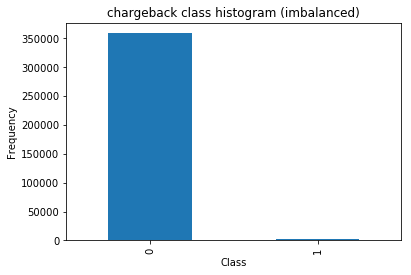

In [39]:
# 필요한 데이터 읽기
charge_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_eu.csv", encoding='utf-8-sig')
charge_na = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_na.csv", encoding='utf-8-sig')
purchase_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')
purchase_na = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')

# 환불 유저와 전체 유저 집합을 구함
def createAbuserDataSet(data_set):
    data_set = data_set[data_set.charge_status >= 60].drop_duplicates(['user_no'], keep='last')
        
    data_set = pd.DataFrame(data_set, columns=['user_no'])
    data_set['Class'] = 1
    return data_set
def createAllDataSet(data_set):
    data_set = pd.DataFrame(data_set, columns=['user_no']).drop_duplicates(['user_no'], keep='last')
    return data_set

charge_eu_abuser = createAbuserDataSet(charge_eu)
charge_na_abuser = createAbuserDataSet(charge_na)

# 전체 유저에서 환불 유저를 뺀 것이 일반 유저
charge_eu_normal = createAllDataSet(charge_eu).drop(charge_eu_abuser.index)
charge_eu_normal['Class'] = 0
charge_na_normal = createAllDataSet(charge_na).drop(charge_na_abuser.index)
charge_na_normal['Class'] = 0
print("eu 일반 유저의 수: ", len(charge_eu_normal))
print("na 일반 유저의 수: ", len(charge_na_normal))
print("eu 환불 유저의 수: ", len(charge_eu_abuser))
print("na 환불 유저의 수: ", len(charge_na_abuser))

# 데이터 통합 및 인덱스 재정렬
charge_all = pd.concat([charge_eu_abuser, charge_eu_normal, charge_na_abuser, charge_na_normal])
charge_all = charge_all.reset_index(drop=True)

print("전체 유저의 수: ", len(charge_all))
print("일반 유저의 비율: ", len(charge_all[charge_all.Class == 0]) / len(charge_all))
print("환불 유저의 비율: ", len(charge_all[charge_all.Class == 1]) / len(charge_all))
count_classes = pd.value_counts(charge_all['Class'], sort=True)
count_classes.plot(kind = 'bar')
plt.title("chargeback class histogram (imbalanced)")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [3]:
# feature 생성 함수 구분
# 첫번째 feature (original featurel들의 kind 계산)
def createFeatureForKind(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[]]

    for user_id in charges.user_no:
        sample = transactions[transactions.user_no == user_id]
        list[0].append(len(sample.drop_duplicates(['standard_country_code'])))
        list[1].append(len(sample.drop_duplicates(['payment_method_no'])))
        list[2].append(len(sample.drop_duplicates(['hash_ip'])))
        list[3].append(len(sample.drop_duplicates(['charge_product_name'])))
          
    charges['standard_country_code_kind'] = list[0]
    charges['payment_method_no_kind'] = list[1]
    charges['hash_ip_kind'] = list[2]
    charges['charge_product_name_kind'] = list[3]

# 두번째 feature ( amount(charge, bonus), transaction 수를 위한 feature 생성)
def createFeatureForAmount(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[],[],[],[]]

    for user_id in charges.user_no:
        sample = transactions[transactions.user_no == user_id]
        list[0].append(np.sum(sample.iloc[:, 6]))
        list[1].append(np.mean(sample.iloc[:, 6]))
        list[2].append(np.std(sample.iloc[:, 6]))
        list[3].append(np.sum(sample.iloc[:, 7]))
        list[4].append(np.mean(sample.iloc[:, 7]))
        list[5].append(np.std(sample.iloc[:, 7]))         
        list[6].append(len(sample.iloc[:, 7]))         
        
    charges['charge_amount_sum'] = list[0]
    charges['charge_amount_avg'] = list[1]
    charges['charge_amount_stddev'] = list[2]
    charges['bonus_amount_sum'] = list[3]
    charges['bonus_amount_avg'] = list[4]
    charges['bonus_amount_stddev'] = list[5]
    charges['transaction_cnt_sum'] = list[6]
    
# 세번째 feature ( transaction 수를 1,2,3,6 개월 단위로 계산)
def getTime(date):
    date = date.replace("-", " ")
    dates = date.split(" ")
    year = dates[0]
    month = dates[1]
    day = dates[2]
    hour = dates[3]
    return str(year), str(month), str(day), str(hour)

def getRangeDate(year, month, day, num):
    m = int(month) - int(num)
    y = year
    d = day
    if m <= 0 :
        m = 12 + int(m)
        y = int(y) - 1
    return str(y), str(m), str(d)

def createFeatureForTransaction(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[],[]]
    
    for user_id in charges.user_no:
        samples = transactions[transactions.user_no == user_id]
        samples = samples.sort_values(by=['charge_datetime'], ascending=False)
        isFirst = True
        lYear, lMonth, lDay, countList = [0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0,0]
        pYear, pMonth, pDay = [0,0,0,0],[0,0,0,0],[0,0,0,0]
        #print(samples)
        for date in samples['charge_datetime']:
            year, month, day, hour = getTime(date)
            if len(month) != 2: month = '0' + month  
            if isFirst:
                lYear[0], lMonth[0], lDay[0] = year, month, day
                lYear[1], lMonth[1], lDay[1] = getRangeDate(lYear[0], lMonth[0], lDay[0], '01')
                lYear[2], lMonth[2], lDay[2] = getRangeDate(lYear[1], lMonth[1], lDay[1], '02')
                lYear[3], lMonth[3], lDay[3] = getRangeDate(lYear[2], lMonth[2], lDay[2], '03')
                pYear[0], pMonth[0], pDay[0] = lYear[1], lMonth[1], lDay[1]
                pYear[1], pMonth[1], pDay[1] = lYear[2], lMonth[2], lDay[2]
                pYear[2], pMonth[2], pDay[2] = lYear[3], lMonth[3], lDay[3]
                pYear[3], pMonth[3], pDay[3] = getRangeDate(lYear[3], lMonth[3], lDay[3], '06')
                isFirst = False
                for i in range(0, 4):
                    if len(pMonth[i]) != 2: pMonth[i] = '0' + pMonth[i]
                    if len(lMonth[i]) != 2: lMonth[i] = '0' + lMonth[i]
                continue
            for i in range(0, 4):
                pValue = int(pYear[i] + pMonth[i] + pDay[i])
                cValue = int(year + month + day)
                lValue = int(lYear[i] + lMonth[i] + lDay[i])
                
                #print(pValue, cValue, lValue, i)
                if pValue <= cValue <= lValue :
                    countList[i] = countList[i] + 1
                    break
        sum = 0
        for i in range(0, 4):
            sum += countList[i]
        countList[4] = len(samples['charge_datetime']) - sum ;
        #print(countList[0], countList[1],countList[2], countList[3], countList[4])
        
        for i in range(0, 5):
            list[i].append(countList[i])
        
    charges['tran_cnt_1_month'] = list[0]
    charges['tran_cnt_2_month'] = list[1]
    charges['tran_cnt_3_month'] = list[2]
    charges['tran_cnt_6_month'] = list[3]
    charges['tran_cnt_else'] = list[4]

In [23]:
# under sampling 과정
number_abuser = len(charge_all[charge_all.Class == 1])
abuser_indices = charge_all[charge_all.Class == 1].index
normal_indices = charge_all[charge_all.Class == 0].index

random_normal_indices = np.random.choice(normal_indices, number_abuser, replace = False)
random_normal_indices = np.array(random_normal_indices)

charge_all_sample_indices = np.concatenate([abuser_indices, random_normal_indices])
charge_all_sample = charge_all.iloc[charge_all_sample_indices, :]

# 모든 transaction 생성
transaction_charge = pd.concat([charge_eu, charge_na])

In [24]:
# 첫번째 feature 생성 후 저장
createFeatureForKind(transaction_charge, charge_all_sample)
#charge_all_sample.to_csv('charge_allForKind.csv')
# 두번째 feature 생성 후 저장
createFeatureForAmount(transaction_charge, charge_all_sample)
#charge_all_sample.to_csv('charge_allForAmount.csv')
# 세번째 feature 생성 후 저장
createFeatureForTransaction(transaction_charge, charge_all_sample)
#charge_all_sample.to_csv('charge_allForMonth.csv')

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [25]:
# 모든 type을 float로 변경함
charge_all_sample.iloc[:, 2:] = charge_all_sample.iloc[:, 2:].astype(np.float)
# 필요없는 key들 drop 과정
charge_all_sample = charge_all_sample.drop(charge_all_sample.columns[0], axis=1)
#charge_all_sample.head()

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
#charge_all_sample = charge_all_sample.drop(charge_all_sample.columns[7:], axis=1)
#charge_all_sample.head()

,Class,charge_amount_sum,charge_amount_avg,charge_amount_stddev,bonus_amount_sum,bonus_amount_avg,bonus_amount_stddev
0,1,33167.0,315.876190,236.270938,6591.0,62.771429,117.742031
1,1,1300.0,433.333333,612.825877,30.0,10.000000,14.142136
2,1,500.0,500.000000,0.000000,0.0,0.000000,0.000000
3,1,10000.0,10000.000000,0.000000,0.0,0.000000,0.000000
4,1,16900.0,5633.333333,5235.986589,1360.0,453.333333,599.184631


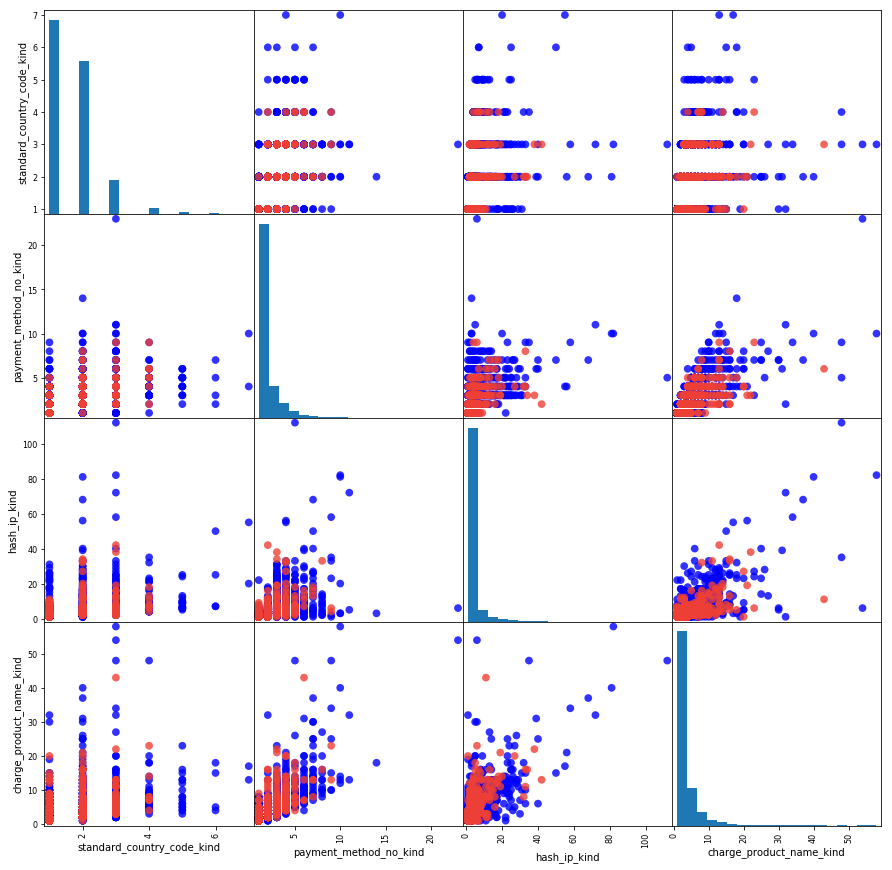

In [7]:
# 첫번째 feature들의 산점도 계산
x_train = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y_train = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']

x_train_feature = x_train.iloc[:, 0:4]

color_wheel = {1: "#ee4035", 
               2: "b" }
colors = y_train["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

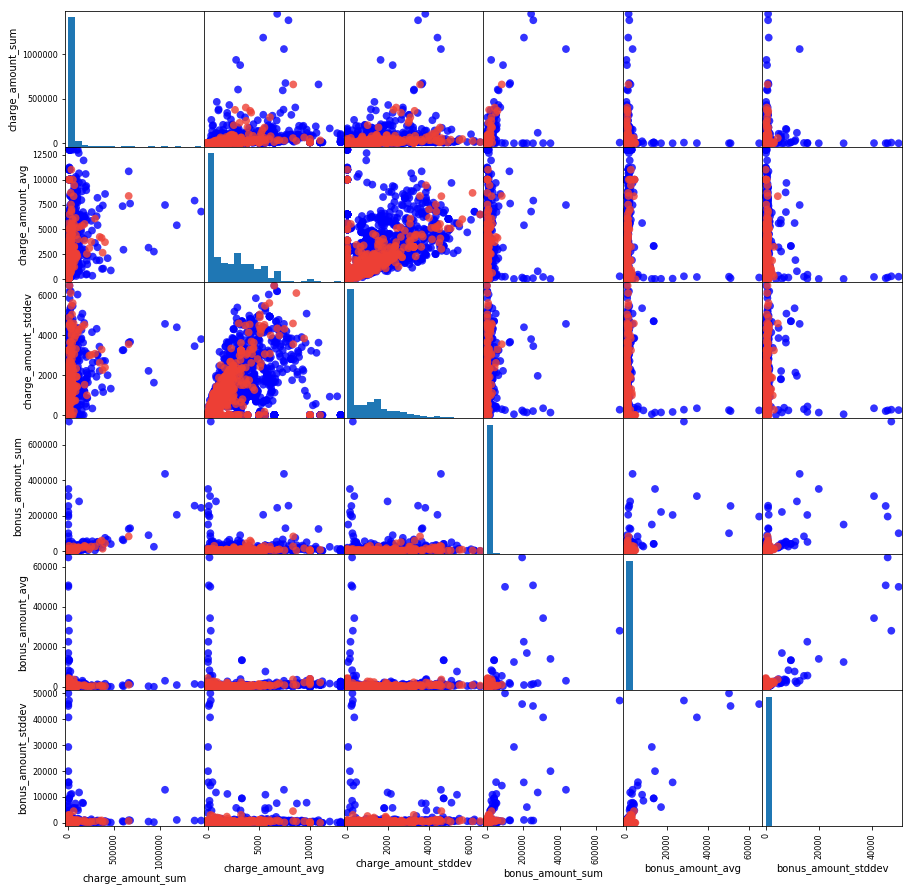

In [8]:
x_train_feature2 = x_train.iloc[:, 4:10]

color_wheel = {1: "#ee4035", 
               2: "b" }
colors = y_train["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature2, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

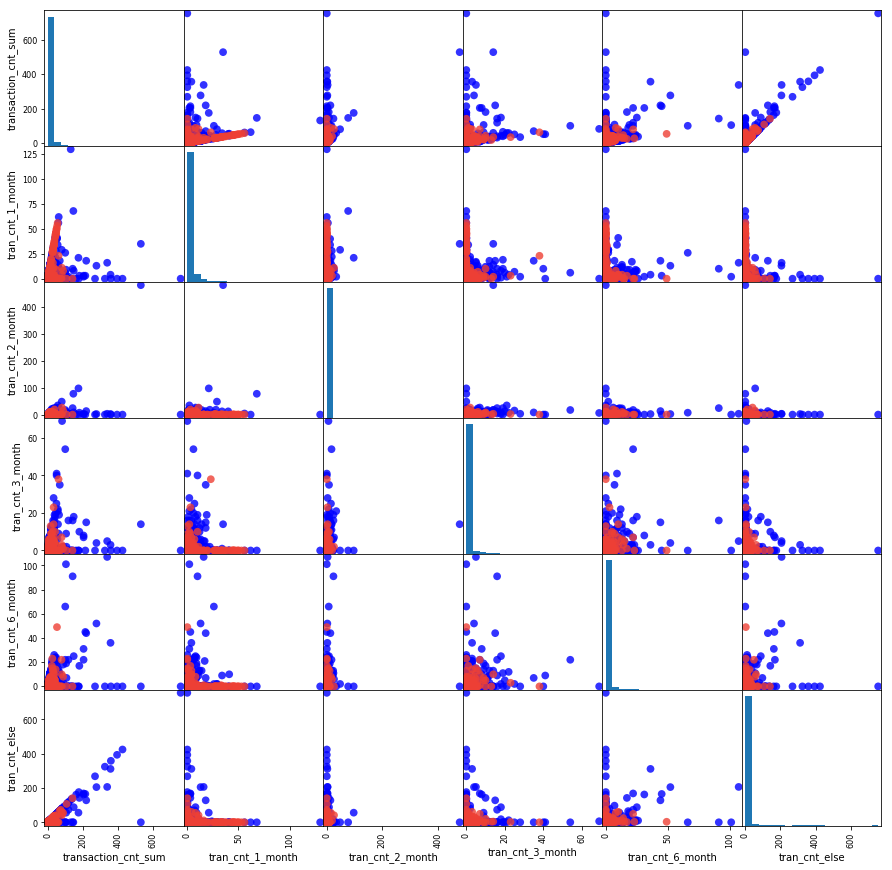

In [9]:
x_train_feature3 = x_train.iloc[:, 10:]

color_wheel = {1: "#ee4035", 
               2: "b" }
colors = y_train["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature3, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

In [8]:
# SMOTE algorithm #####
charge_all = pd.read_csv("C:/Users/jgb710/Desktop/webzen/jaegeun/charge_all/charge_all2.csv", encoding='utf-8-sig')
# 모든 type을 float로 변경함
charge_all.iloc[:, 5:] = charge_all.iloc[:, 5:].astype(np.float)
# 필요없는 key들 drop 과정
charge_all = charge_all.drop(charge_all.columns[:4], axis=1)

In [ ]:
# SMOTE algorithm #####
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

X = charge_all.iloc[:, charge_all.columns != 'Class']
y = charge_all.iloc[:, charge_all.columns == 'Class']

sm = SMOTE(random_state=42) 
X_res, y_res = sm.fit_sample(X, y)
#########################

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)

model2 = svm.SVC()
model3 = DecisionTreeClassifier()

model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

print("훈련(SVM) 세트 정확도: {:.3f}".format(model2.score(X_train, y_train)))
print("테스트(SVM) 세트 정확도: {:.3f}".format(model2.score(X_test, y_test)))
print("훈련(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_train, y_train)))
print("테스트(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_test, y_test)))

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# SMOTE algorithm #####
model3.feature_importances_

In [ ]:
# SMOTE algorithm #####
from sklearn.metrics import *

print("SVM 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model2.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("Decision Tree 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model3.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

In [29]:
# sample data modeling
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *

X = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = RandomForestClassifier(n_estimators=100, random_state=2)
model2 = svm.SVC()
model3 = DecisionTreeClassifier(max_depth = 4)
model4 = GaussianNB()

model.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
print("훈련(randomforest) 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
print("테스트(randomforest) 세트 정확도: {:.3f}".format(model.score(X_test, y_test)))
print("훈련(SVM) 세트 정확도: {:.3f}".format(model2.score(X_train, y_train)))
print("테스트(SVM) 세트 정확도: {:.3f}".format(model2.score(X_test, y_test)))
print("훈련(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_train, y_train)))
print("테스트(DecisionTree) 세트 정확도: {:.3f}".format(model3.score(X_test, y_test)))
print("훈련(naive-bayes) 세트 정확도: {:.3f}".format(model4.score(X_train, y_train)))
print("테스트(naive-bayes) 세트 정확도: {:.3f}".format(model4.score(X_test, y_test)))

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련(randomforest) 세트 정확도: 0.994
테스트(randomforest) 세트 정확도: 0.897
훈련(SVM) 세트 정확도: 0.994
테스트(SVM) 세트 정확도: 0.785
훈련(DecisionTree) 세트 정확도: 0.890
테스트(DecisionTree) 세트 정확도: 0.876
훈련(naive-bayes) 세트 정확도: 0.695
테스트(naive-bayes) 세트 정확도: 0.669


In [40]:
model.feature_importances_

array([ 0.85,  0.08,  0.04,  0.01,  0.  ,  0.02])

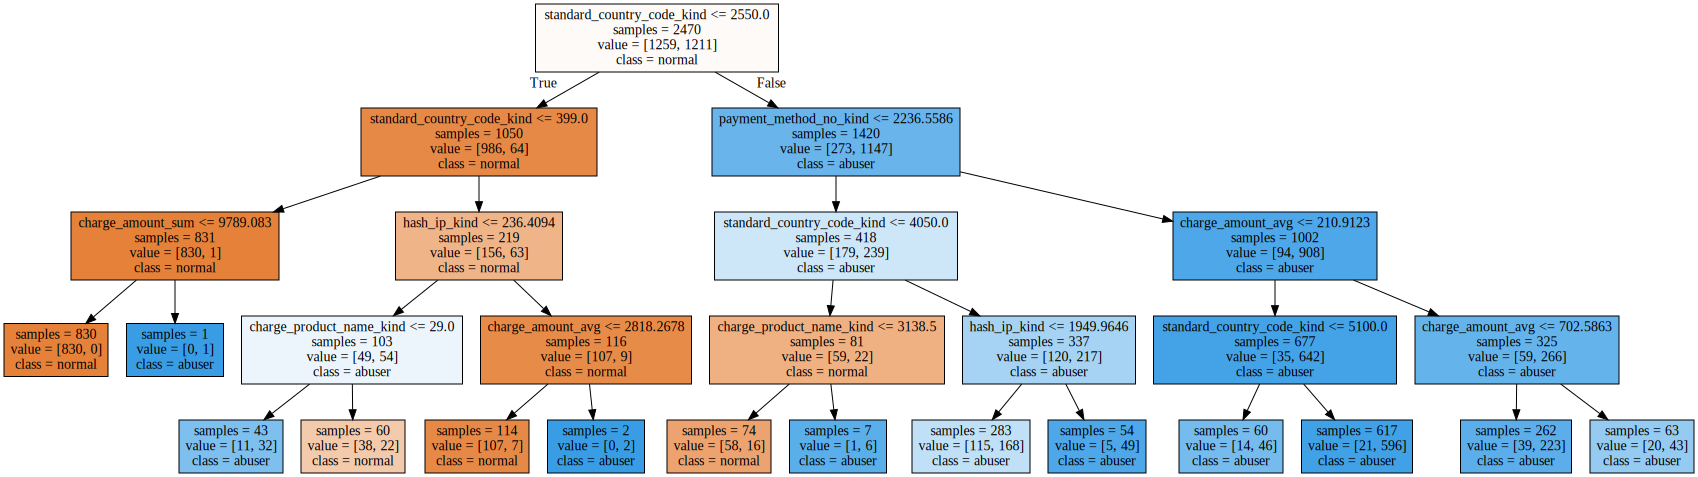

In [31]:
from sklearn.tree import export_graphviz

features=['standard_country_code_kind','payment_method_no_kind','hash_ip_kind','charge_product_name_kind',
          'charge_amount_sum','charge_amount_avg','charge_amount_stddev','bonus_amount_sum',
          'bonus_amount_avg','bonus_amount_stddev','transaction_cnt_sum','tran_cnt_1_month',
          'tran_cnt_2_month','tran_cnt_3_month','tran_cnt_6_month','tran_cnt_else']

export_graphviz(model3, out_file="mytree.dot",class_names=['normal',"abuser"],
    feature_names=features, impurity=False, filled=True)
###visualize the .dot file. Need to install graphviz seperately at first 
import graphviz
with open("mytree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

#
#visualize_tree(model3, features)

In [32]:
from sklearn.metrics import *

print("SVM 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model2.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("Decision Tree 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model3.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("naive bayes 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model4.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

print("Random Forest 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
y_pred = model.predict(X_test)
print("accuracy- score: {}".format(accuracy_score(y_test, y_pred)))
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
print("AUC-Curve:{}".format(roc_auc))
print()
print(classification_report(y_test, y_pred))

SVM 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.7851941747572816
precision- score: 0.7126436781609196
recall- score: 0.9954128440366973
f1- score: 0.830622009569378
AUC-Curve:0.7721909581008228

             precision    recall  f1-score   support

          0       0.99      0.55      0.71       388
          1       0.71      1.00      0.83       436

avg / total       0.84      0.79      0.77       824

Decision Tree 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.8762135922330098
precision- score: 0.8366935483870968
recall- score: 0.9518348623853211
f1- score: 0.8905579399141631
AUC-Curve:0.8715359878936915

             precision    recall  f1-score   support

          0       0.94      0.79      0.86       388
          1       0.84      0.95      0.89       436

avg / total       0.88      0.88      0.88       824

naive bayes 정확도~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy- score: 0.6686893203883495
precision- score: 0.9267015706806

In [33]:
from sklearn.cross_validation import KFold, cross_val_score

def printing_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data),10, shuffle = False) 

    recall_accs = []
    # accruracy, precision, recall, f1-score
    avg = [0.0, 0.0, 0.0, 0.0]
    for iteration, indices in enumerate(fold,start=1):
        #print(indices)
        model = RandomForestClassifier(n_estimators=100, random_state=2)
        #model = svm.SVC()
        #model = DecisionTreeClassifier()
        #model = GaussianNB()
        
        model.fit(x_train_data.iloc[indices[0],:], y_train_data.iloc[indices[0],:].values.ravel())
        y_pred = model.predict(x_train_data.iloc[indices[1],:].values)

        accuracy_acc = accuracy_score(y_train_data.iloc[indices[1],:].values, y_pred)
        precision_acc = precision_score(y_train_data.iloc[indices[1],:].values, y_pred)
        recall_acc = recall_score(y_train_data.iloc[indices[1],:].values, y_pred)
        f1_acc = f1_score(y_train_data.iloc[indices[1],:].values, y_pred)
        
        #recall_accs.append(recall_acc)
        avg[0] += accuracy_acc
        avg[1] += precision_acc
        avg[2] += recall_acc
        avg[3] += f1_acc
        #print('Iteration ', iteration,': recall score = ', recall_acc)
    print('10-fold avg accuracy_acc score =', avg[0] / 10)
    print('10-fold avg precision_acc score =', avg[1] / 10)
    print('10-fold avg recall_acc score =', avg[2] / 10)
    print('10-fold avg f1_acc score =', avg[3] / 10)

In [34]:
printing_Kfold_scores(X_train, y_train)

10-fold avg accuracy_acc score = 0.884210526316
10-fold avg precision_acc score = 0.85938411431
10-fold avg recall_acc score = 0.913726564145
10-fold avg f1_acc score = 0.8852415582


In [35]:
import itertools

from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.940366972477


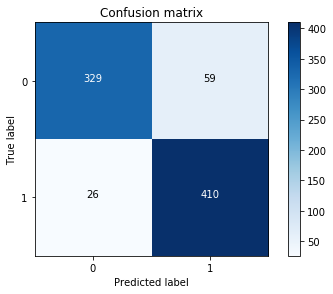

In [36]:
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

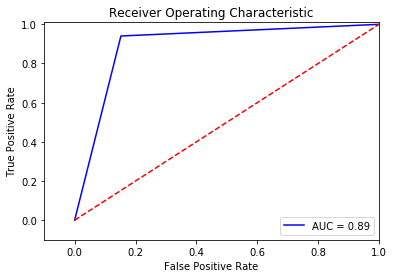

In [37]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()